In [1]:
import os
import importlib
import pyhxexpress as hxex
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import random
#import config  
#import hdxms_params_22Dec2023 as config
import test_config as config


def hxex_reload():
    importlib.reload(hxex)
    importlib.reload(config)
    hxex.config = config

hxex_reload()
#help(hxex)

#hxex.config.Hide_Figure_Output = False

# hxex.config.Output_DIR = os.path.join(config.Data_DIR,'output_fixedpops_'+str(config.date),'')
# if not os.path.exists(hxex.config.Output_DIR): os.makedirs(hxex.config.Output_DIR)


#metadf = hxex.get_metadf()
#filtered = metadf[0:1]
#filtered = hxex.filter_metadf(metadf,index=[*range(0,2)])#,charge=2, samples='B1B5')
#display(filtered)
#hxex.run_hdx_fits(filtered)
#hxex.run_hdx_fits(metadf)

In [58]:
RandomSeed=2024
random.seed(RandomSeed)
def random_seq(length):
    AA = 'ARNDCQEGHILKMFPSTWYV'
    return "".join(random.choice(AA) for i in range(length))

def get_peptides(num_peptides,cutoff=4):
    peptide_list = {}
    n_in_list = 0
    while n_in_list < num_peptides:
        #peptide_list.append(random_seq(random.randint(5,20)))
        peptide = random_seq(random.randint(5,20))
        namides = hxex.count_amides(peptide)
        if namides >= cutoff:
            peptide_list[peptide] = namides
            n_in_list += 1
    return peptide_list

def random_params(n_curves,max_n_amides,):
    rng=np.random.default_rng()
    log_scaler = 0.0  
    nexs = list(max_n_amides*rng.random(n_curves))

    sampled = rng.random(n_curves*2) #array for both mus and fracs
    mus =  list(sampled[0:n_curves]) 
    fracs = sampled[-n_curves:]
    fracs = list(fracs/np.sum(fracs))

    initial_estimate = [ log_scaler ] + nexs + mus + fracs
    
    return initial_estimate

peptides_list = get_peptides(1000)

In [106]:
#proposed features ['env_width','env_symm','max_namides']
noise = 0.01
simulated_spectrum = pd.DataFrame()
simulated_spectra = pd.DataFrame()
#simulated_spectra = simulated_spectra.asytpe(object)
for peptide,namides in peptides_list.items():
    charge = 1
    hxex.Current_Isotope= hxex.get_na_isotope(peptide,charge)
    TD_max_spectrum = hxex.n_binom_isotope(namides+5,0.0, namides, 0.999, 1.0) #can't set Nex to exactly 1.0, nCk gives error
    TD_spec = pd.DataFrame(zip(np.arange(len(TD_max_spectrum)),TD_max_spectrum),columns=['mz','Intensity'])
    [left,right] = hxex.get_mz_env(0.1*max(TD_max_spectrum),TD_spec,colname='Intensity')
    TD_env_width = (right - left)*charge

    for npops in range(1,4):
        #npops = 3
        charge = 1
        params = random_params(npops,namides)

        simulated_spectrum.loc[0,'peptide'] = peptide
        simulated_spectrum.loc[0,'max_namides'] = namides
        simulated_spectrum.loc[0,'charge'] = charge
        simulated_spectrum.loc[0,'npops'] = npops
        string_params = ','.join(str(x) for x in params)
        #string_params.split(',')
        simulated_spectrum.loc[0,'params'] = string_params
        
        spectrum = hxex.n_binom_isotope(namides+5,*params)
        spectrum_with_noise = spectrum + np.random.normal(0., noise, len(spectrum))
        spectrum_with_noise = [max(0,s) for s in spectrum_with_noise]
        spec_df = pd.DataFrame(zip(np.arange(len(spectrum)),spectrum,spectrum_with_noise),columns=['mz','Intensity','Inoisey'])
        [left,right],env_Int = hxex.get_mz_env(0.1*max(spectrum),spec_df,colname='Intensity',pts=True)
        env_width = (right - left)*charge
        env_symm = 2.0 - (max(spectrum) - env_Int)/max(spectrum)
        simulated_spectrum['TD_env_width'] = TD_env_width
        simulated_spectrum.loc[0,'env_width'] = env_width
        simulated_spectrum.loc[0,'env_symm'] = env_symm
        [left,right],env_Int = hxex.get_mz_env(0.1*max(spectrum_with_noise),spec_df,colname='Inoisey',pts=True)
        env_width = (right - left)*charge
        env_symm = 2.0 - (max(spectrum_with_noise) - env_Int)/max(spectrum_with_noise)
        simulated_spectrum.loc[0,'env_width_noise'] = env_width
        simulated_spectrum.loc[0,'env_symm_noise'] = env_symm
        
        simulated_spectra = pd.concat([simulated_spectra,simulated_spectrum],ignore_index = True).reset_index(drop = True)
        # plt.vlines(ymin=np.zeros(len(spectrum)),ymax=spectrum,x=np.arange(len(spectrum)))
        # plt.vlines(ymin=np.zeros(len(spectrum)),ymax=spectrum_with_noise,x=np.arange(len(spectrum)),color='r')
        # plt.show()

In [107]:
simulated_spectra


,peptide,max_namides,charge,npops,params,TD_env_width,env_width,env_symm,env_width_noise,env_symm_noise
0,QYIEFHWGSKFTVEIWLTNE,19.0,1.0,1.0,"0.0,7.32201903870183,0.3310598841047607,1.0",5.487401,7.879869,1.100000,7.825997,1.142832
1,QYIEFHWGSKFTVEIWLTNE,19.0,1.0,2.0,"0.0,2.1184145240317678,1.8440172257130296,0.80...",5.487401,6.577361,1.100000,7.081549,1.133745
2,QYIEFHWGSKFTVEIWLTNE,19.0,1.0,3.0,"0.0,3.4557342614452993,1.3360547728191574,5.62...",5.487401,7.916317,1.563377,14.548311,1.619330
3,CWEFRKFPDCLMLKELFFL,17.0,1.0,1.0,"0.0,14.725869321038683,0.019975753175494826,1.0",5.873087,5.719796,1.578004,5.181166,1.535669
4,CWEFRKFPDCLMLKELFFL,17.0,1.0,2.0,"0.0,10.331008798125154,4.694380368546482,0.826...",5.873087,10.528748,1.100000,14.522171,1.100000
...,...,...,...,...,...,...,...,...,...,...
2995,GFNDGASSYA,9.0,1.0,2.0,"0.0,1.744829868168559,7.680027869921227,0.8448...",3.400860,9.768160,1.100000,9.840053,1.100000
2996,GFNDGASSYA,9.0,1.0,3.0,"0.0,0.38023801870461627,6.415224177189089,6.49...",3.400860,6.979428,1.648036,7.178877,1.691244
2997,NKGQD,4.0,1.0,1.0,"0.0,1.874637603407323,0.06510252115202131,1.0",2.684530,1.975135,2.000000,2.159574,2.000000
2998,NKGQD,4.0,1.0,2.0,"0.0,0.7525167936617327,2.92305828207222,0.2742...",2.684530,4.743884,2.000000,4.747990,2.000000


In [125]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

tf.keras.utils.set_random_seed(256)

from sklearn.model_selection import train_test_split

X_features = ['env_width','env_symm','max_namides','TD_env_width']
#X_features = ['env_width_noise','env_symm_noise','max_namides'] #performing very poorly

data = simulated_spectra.copy()
X = data[X_features].to_numpy()
y = data[['npops']].to_numpy().ravel() - 1 #-1 to be 0,1,2 

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# normalization_layer = tf.keras.layers.experimental.preprocessing.Normalization()
# normalization_layer.adapt(X)

X_train, X_val, y_train, y_val = train_test_split(X,y,stratify=y,test_size=0.15)

#y = [1 if yt > 1 else 0 for yt in y_train]
#y = np.array(y)


18/18 [==============================] - 0s 829us/step


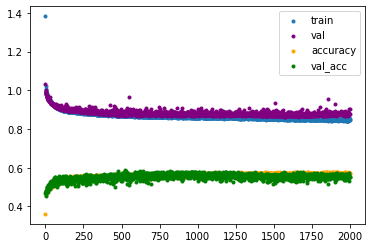

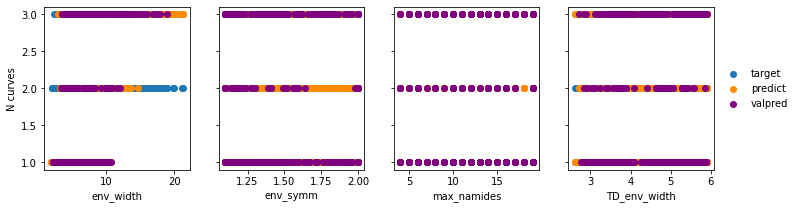

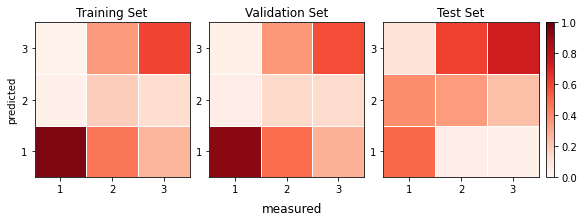

In [126]:
class GetWeights(tf.keras.callbacks.Callback):
    # Keras callback which collects values of weights and biases at each epoch
    def __init__(self):
        super(GetWeights, self).__init__()
        self.weight_dict = {}

    def on_epoch_end(self, epoch, logs=None):
        # this function runs at the end of each epoch

        # loop over each layer and get weights and biases
        for layer_i in range(len(self.model.layers)):
            w = self.model.layers[layer_i].get_weights()[0]
            b = self.model.layers[layer_i].get_weights()[1]
            #print('Layer %s has weights of shape %s and biases of shape %s' %(
            #    layer_i, np.shape(w), np.shape(b)))

            # save all weights and biases inside a dictionary
            if epoch == 0:
                # create array to hold weights and biases
                self.weight_dict['w_'+str(layer_i+1)] = w
                self.weight_dict['b_'+str(layer_i+1)] = b
            else:
                # append new weights to previously-created weights array
                self.weight_dict['w_'+str(layer_i+1)] = np.dstack(
                    (self.weight_dict['w_'+str(layer_i+1)], w))
                # append new weights to previously-created weights array
                self.weight_dict['b_'+str(layer_i+1)] = np.dstack(
                    (self.weight_dict['b_'+str(layer_i+1)], b))

dense_model = Sequential(
    [ 
        #Dense(64, activation = 'relu'),
        Dense(25, activation = 'relu'),
        #Dropout(0.1),
        Dense(15, activation = 'relu'),
        Dense(3, activation = 'linear')   
    ]
)

preferred_model = dense_model ##

preferred_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999),
    metrics=['accuracy']
)

gw = GetWeights()
history = preferred_model.fit(
    X_train,y_train, verbose=0,callbacks=[gw],
    validation_data=(X_val,y_val),
    epochs=2000
)

# for k,v in gw.weight_dict.items():
#     print (k,v)
#test = gw.weight_dict['w_1'][0]
plt.scatter(np.arange(0,len(history.history['loss'])),history.history['loss'],label='train',marker='.');
plt.scatter(np.arange(0,len(history.history['val_loss'])),history.history['val_loss'],color='purple',label='val',marker='.');
plt.scatter(np.arange(0,len(history.history['accuracy'])),history.history['accuracy'],label='accuracy',marker='.',color='orange');
plt.scatter(np.arange(0,len(history.history['val_accuracy'])),history.history['val_accuracy'],color='green',label='val_acc',marker='.');
plt.legend()

train_pred = preferred_model.predict(X_train)
val_pred = preferred_model.predict(X_val)
#sm_preferred = tf.nn.softmax(p_preferred).numpy()
y_trainpred = np.argmax(train_pred,axis=1)
y_valpred = np.argmax(val_pred,axis=1)
# plot predictions and targets vs original features    
fig,ax=plt.subplots(1,len(X_features),figsize=(12,3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train+1, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train[:,i],y_trainpred+1,color="darkorange", label = 'predict')
    ax[i].scatter(X_val[:,i],y_valpred+1,color="purple", label = 'valpred',marker='o')
ax[0].set_ylabel("N curves"); 
ax[len(X_features)-1].legend(loc='center left',bbox_to_anchor=(1,0.5),frameon=False);
#fig.suptitle("target versus prediction")

testfile = os.path.join(hxex.config.Data_DIR,'output_11Jan2024','data_fits11Jan2024.csv')
test_data = pd.read_csv(testfile).drop('Index',axis=1)

test_peptides = test_data['peptide'].unique()
for tpeptide in test_peptides:
    namides = hxex.count_amides(tpeptide)
    hxex.Current_Isotope= hxex.get_na_isotope(tpeptide,charge=1)
    TD_max_spectrum = hxex.n_binom_isotope(namides+5,0.0, namides, 0.999, 1.0) #can't set Nex to exactly 1.0, nCk gives error
    TD_spec = pd.DataFrame(zip(np.arange(len(TD_max_spectrum)),TD_max_spectrum),columns=['mz','Intensity'])
    [left,right] = hxex.get_mz_env(0.1*max(TD_max_spectrum),TD_spec,colname='Intensity')
    TD_env_width = (right - left)*charge
    test_data.loc[test_data['peptide'] == tpeptide,['TD_env_width']] = TD_env_width

X_test = test_data[X_features].to_numpy().astype('float32')
y_test = test_data['solution_npops'].to_numpy().astype('float32').ravel()-1
test_pred = preferred_model.predict(X_test)
#sm_preferred = tf.nn.softmax(test_pred).numpy()
y_testpred = np.argmax(test_pred,axis=1)

fig2,ax2=plt.subplots(1,3,figsize=(8,3),sharey=False,constrained_layout=True)
offset = 1
heatmap, xedges, yedges = np.histogram2d(y_trainpred+offset,y_train+offset,bins=3)
heatmap = heatmap/heatmap.sum(axis=0)
hm = ax2[0].pcolormesh(xedges,yedges,heatmap,cmap='Reds',vmin=0,vmax=1.0,edgecolors='w')
heatmap, xedges, yedges = np.histogram2d(y_valpred+offset,y_val+offset,bins=3)
heatmap = heatmap/heatmap.sum(axis=0)
hm = ax2[1].pcolormesh(xedges,yedges,heatmap,cmap='Reds',vmin=0,vmax=1.0,edgecolors='w')
heatmap, xedges, yedges = np.histogram2d(y_testpred+offset,y_test+offset,bins=3)
heatmap = heatmap/heatmap.sum(axis=0)
hm = ax2[2].pcolormesh(xedges,yedges,heatmap,cmap='Reds',vmin=0,vmax=1.0,edgecolors='w')

ax2[0].set_ylabel("predicted")
fig2.supxlabel("measured")
for i in range(3):
    ax2[i].set_xticks([4/3,2,8/3]); ax2[i].set_yticks([4/3,2,8/3]);
    ax2[i].set_xticklabels(['1','2','3']); ax2[i].set_yticklabels(['1','2','3']); 
for axes in ax2[:3]:
    axes.set_aspect(1)
fig2.colorbar(hm,fraction=0.05,pad=0.05);
ax2[0].set_title("Training Set")
ax2[1].set_title("Validation Set")
ax2[2].set_title("Test Set");
#fig2.tight_layout() #not compatible with constrained_layout
#heatmap

plt.show()

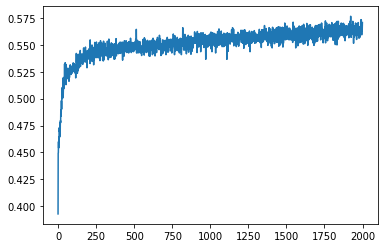

In [44]:
plt.plot(history.history['accuracy'])

18/18 [==============================] - 0s 968us/step


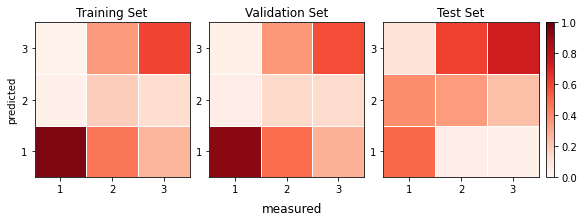

In [123]:

testfile = os.path.join(hxex.config.Data_DIR,'output_11Jan2024','data_fits11Jan2024.csv')
test_data = pd.read_csv(testfile).drop('Index',axis=1)

test_peptides = test_data['peptide'].unique()
for tpeptide in test_peptides:
    namides = hxex.count_amides(tpeptide)
    hxex.Current_Isotope= hxex.get_na_isotope(tpeptide,charge=1)
    TD_max_spectrum = hxex.n_binom_isotope(namides+5,0.0, namides, 0.999, 1.0) #can't set Nex to exactly 1.0, nCk gives error
    TD_spec = pd.DataFrame(zip(np.arange(len(TD_max_spectrum)),TD_max_spectrum),columns=['mz','Intensity'])
    [left,right] = hxex.get_mz_env(0.1*max(TD_max_spectrum),TD_spec,colname='Intensity')
    TD_env_width = (right - left)*charge
    test_data.loc[test_data['peptide'] == tpeptide,['TD_env_width']] = TD_env_width

X_test = test_data[X_features].to_numpy().astype('float32')
y_test = test_data['solution_npops'].to_numpy().astype('float32').ravel()-1
test_pred = preferred_model.predict(X_test)
#sm_preferred = tf.nn.softmax(p_preferred).numpy()
y_testpred = np.argmax(test_pred,axis=1)

fig2,ax2=plt.subplots(1,3,figsize=(8,3),sharey=False,constrained_layout=True)
offset = 1
heatmap, xedges, yedges = np.histogram2d(y_trainpred+offset,y_train+offset,bins=3)
heatmap = heatmap/heatmap.sum(axis=0)
hm = ax2[0].pcolormesh(xedges,yedges,heatmap,cmap='Reds',vmin=0,vmax=1.0,edgecolors='w')
heatmap, xedges, yedges = np.histogram2d(y_valpred+offset,y_val+offset,bins=3)
heatmap = heatmap/heatmap.sum(axis=0)
hm = ax2[1].pcolormesh(xedges,yedges,heatmap,cmap='Reds',vmin=0,vmax=1.0,edgecolors='w')
heatmap, xedges, yedges = np.histogram2d(y_testpred+offset,y_test+offset,bins=3)
heatmap = heatmap/heatmap.sum(axis=0)
hm = ax2[2].pcolormesh(xedges,yedges,heatmap,cmap='Reds',vmin=0,vmax=1.0,edgecolors='w')

ax2[0].set_ylabel("predicted")
fig2.supxlabel("measured")
for i in range(3):
    ax2[i].set_xticks([4/3,2,8/3]); ax2[i].set_yticks([4/3,2,8/3]);
    ax2[i].set_xticklabels(['1','2','3']); ax2[i].set_yticklabels(['1','2','3']); 
for axes in ax2[:3]:
    axes.set_aspect(1)
fig2.colorbar(hm,fraction=0.05,pad=0.05);
ax2[0].set_title("Training Set")
ax2[1].set_title("Validation Set")
ax2[2].set_title("Test Set");
#fig2.tight_layout() #not compatible with constrained_layout
#heatmap

In [18]:
# save the model for future use
#preferred_model.save(os.path.join(hxex.config.Data_DIR,'model_1000peps_nonoise.keras'))

In [111]:
#preferred_model.metrics_names
for k,v in history.history.items():
    print (k)

loss
accuracy
val_loss
val_accuracy


[0.0, 9.002414419541058, 0.8778295766655281, 1.0]

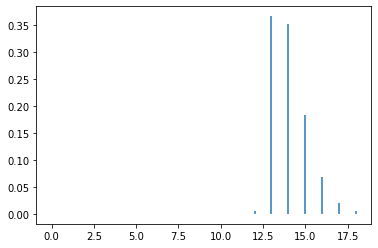

In [102]:
peptide = 'APTKAKRRVVQREKR'
namides = hxex.count_amides(peptide)
hxex.Current_Isotope = hxex.get_na_isotope(peptide,1.0)
TD_max_spectrum = hxex.n_binom_isotope(namides+5,0.0, namides, 0.999, 1.0)
plt.vlines(ymin = 0, ymax=TD_max_spectrum,x=np.arange(0,len(TD_max_spectrum)))
random_params(1,namides)

In [113]:
test_data

,time,rep,centroid,sample,peptide,peptide_range,charge,env_width,env_symm,max_namides,...,iNex_2,iNex_std_2,icentroid_3,iD_corr3,ipop_3,ipop_std_3,imu_3,iNex_3,iNex_std_3,solution_npops
0,0,1,556.576154,LeuEnk_HI,YGGFL,0001-0005,1,1.773513,2.000000,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,60,1,557.541682,LeuEnk_HI,YGGFL,0001-0005,1,3.731877,1.667691,4,...,2.000000,5.080188e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,120,1,558.415242,LeuEnk_HI,YGGFL,0001-0005,1,4.744240,1.156377,4,...,3.930205,2.993199e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,180,1,559.318773,LeuEnk_HI,YGGFL,0001-0005,1,5.008303,1.100000,4,...,3.857548,1.100391e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,240,1,558.186090,LeuEnk_HI,YGGFL,0001-0005,1,5.397880,2.000000,4,...,3.912723,1.126586e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,19,1,643.094765,pep42_LO,RDKVQKEYALFYKLD,0001-0015,3,10.632609,1.100000,14,...,17.901191,1.678293e+01,641.470963,6.113526,0.208744,1.0,0.862111,6.000000,1.569593e+08,2
562,20,1,641.259406,pep42_LO,RDKVQKEYALFYKLD,0001-0015,3,16.164550,1.747186,14,...,3.000000,2.828102e-03,642.732614,10.566175,0.381553,1.0,0.425777,20.983282,7.532734e+07,3
563,21,1,641.691564,pep42_LO,RDKVQKEYALFYKLD,0001-0015,3,17.018653,1.764202,14,...,21.000000,4.145130e+01,643.724030,14.065104,0.279575,1.0,0.909535,13.060313,4.760520e+03,3
564,22,1,642.450123,pep42_LO,RDKVQKEYALFYKLD,0001-0015,3,15.663056,1.100000,14,...,10.000001,7.937666e+00,643.698075,13.973503,0.443656,1.0,0.913801,12.898341,2.882567e+01,3


In [122]:
test_data

,time,rep,centroid,sample,peptide,peptide_range,charge,env_width,env_symm,max_namides,...,iNex_std_2,icentroid_3,iD_corr3,ipop_3,ipop_std_3,imu_3,iNex_3,iNex_std_3,solution_npops,TD_env_width
0,0,1,556.576154,LeuEnk_HI,YGGFL,0001-0005,1,1.773513,2.000000,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.774605
1,60,1,557.541682,LeuEnk_HI,YGGFL,0001-0005,1,3.731877,1.667691,4,...,5.080188e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.774605
2,120,1,558.415242,LeuEnk_HI,YGGFL,0001-0005,1,4.744240,1.156377,4,...,2.993199e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.774605
3,180,1,559.318773,LeuEnk_HI,YGGFL,0001-0005,1,5.008303,1.100000,4,...,1.100391e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.774605
4,240,1,558.186090,LeuEnk_HI,YGGFL,0001-0005,1,5.397880,2.000000,4,...,1.126586e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.774605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,19,1,643.094765,pep42_LO,RDKVQKEYALFYKLD,0001-0015,3,10.632609,1.100000,14,...,1.678293e+01,641.470963,6.113526,0.208744,1.0,0.862111,6.000000,1.569593e+08,2,4.754315
562,20,1,641.259406,pep42_LO,RDKVQKEYALFYKLD,0001-0015,3,16.164550,1.747186,14,...,2.828102e-03,642.732614,10.566175,0.381553,1.0,0.425777,20.983282,7.532734e+07,3,4.754315
563,21,1,641.691564,pep42_LO,RDKVQKEYALFYKLD,0001-0015,3,17.018653,1.764202,14,...,4.145130e+01,643.724030,14.065104,0.279575,1.0,0.909535,13.060313,4.760520e+03,3,4.754315
564,22,1,642.450123,pep42_LO,RDKVQKEYALFYKLD,0001-0015,3,15.663056,1.100000,14,...,7.937666e+00,643.698075,13.973503,0.443656,1.0,0.913801,12.898341,2.882567e+01,3,4.754315


In [128]:
sm_train = tf.nn.softmax(train_pred).numpy()
sm_val = tf.nn.softmax(val_pred).numpy()
sm_test = tf.nn.softmax(test_pred).numpy()

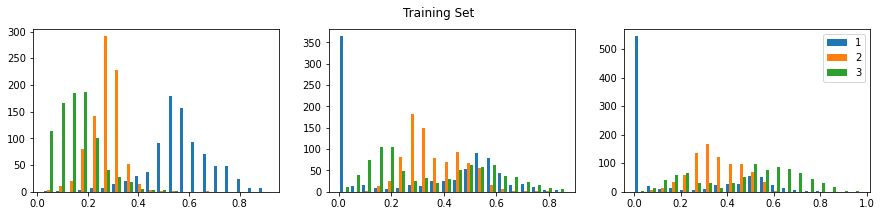

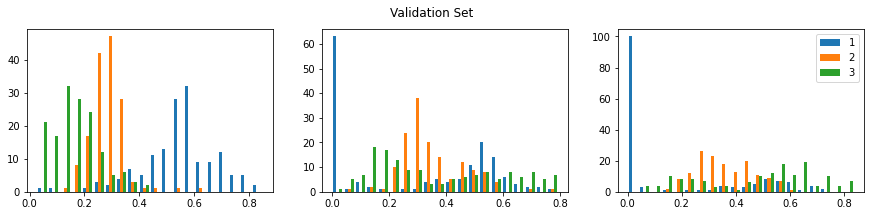

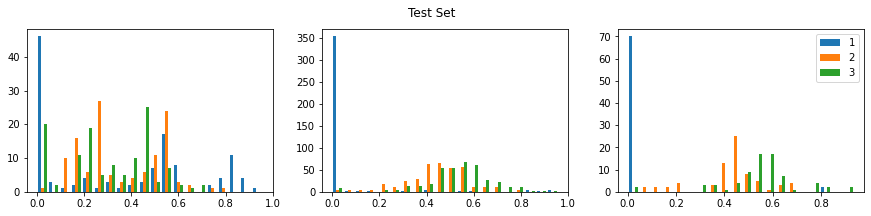

In [143]:
sm_train_1 = sm_train[y_train == 0]
sm_train_2 = sm_train[y_train == 1]
sm_train_3 = sm_train[y_train == 2]
fig,ax=plt.subplots(1,3,figsize=(15,3))
ax[0].hist(sm_train_1,bins=20,label=['1','2','3'])
ax[1].hist(sm_train_2,bins=20,label=['1','2','3'])
ax[2].hist(sm_train_3,bins=20,label=['1','2','3'])
plt.legend();
fig.suptitle("Training Set")
plt.show()
sm_val_1 = sm_val[y_val == 0]
sm_val_2 = sm_val[y_val == 1]
sm_val_3 = sm_val[y_val == 2]
fig,ax=plt.subplots(1,3,figsize=(15,3))
ax[0].hist(sm_val_1,bins=20,label=['1','2','3'])
ax[1].hist(sm_val_2,bins=20,label=['1','2','3'])
ax[2].hist(sm_val_3,bins=20,label=['1','2','3'])
plt.legend();
fig.suptitle("Validation Set")
plt.show()
sm_test_1 = sm_test[y_test == 0]
sm_test_2 = sm_test[y_test == 1]
sm_test_3 = sm_test[y_test == 2]
fig,ax=plt.subplots(1,3,figsize=(15,3))
ax[0].hist(sm_test_1,bins=20,label=['1','2','3'])
ax[1].hist(sm_test_2,bins=20,label=['1','2','3'])
ax[2].hist(sm_test_3,bins=20,label=['1','2','3'])
plt.legend();
fig.suptitle("Test Set")
plt.show()